# Einführung PyTorch

### Torch Tensor als zentrales Objekt

In [1]:
import torch

x = torch.tensor([10.5, 5.5])
print(x) #tensor([10.5000,  5.5000])

tensor([10.5000,  5.5000])


### Torch Tensor als zentrales Objekt

In [2]:
x = torch.rand(5, 3)
y = torch.zeros(5, 3)
z = torch.ones(5, 3)

### Datentyp und Speichergrößenzuweisung

In [3]:
float64 = torch.tensor([10, 5],dtype=torch.double)
float32 = torch.tensor([10, 5],dtype=torch.float)
int32 = torch.tensor([10, 5],dtype=torch.int)
int16 = torch.tensor([10, 5],dtype=torch.short)

### Mathematische Operationen mit Tensoren

In [4]:
a = torch.tensor([10, 5])
b = torch.tensor([4, 12])
print(a+b) #tensor([14, 17])
print(a-b) #tensor([ 6, -7])
print(a*b) #tensor([40, 60])
print(a/b) #tensor([2, 0])
print(torch.dot(a, b)) #tensor(100)

tensor([14, 17])
tensor([ 6, -7])
tensor([40, 60])
tensor([2.5000, 0.4167])
tensor(100)


### Formveränderung mit Torch Tensoren

In [5]:
x = torch.ones(6, 3, 10)
x.view(18,10) #valid shape
x.view(9,20) #valid shape
x.view(9,1,5,4) #valid shape
x.view(10,12) #invalid shape

RuntimeError: shape '[10, 12]' is invalid for input of size 180

### Integration mit Numpy

In [6]:
import numpy as np

x = np.array([10,5])
y = torch.from_numpy(x)
z = y.numpy()
print(type(x)) #<class 'numpy.ndarray'>
print(type(y)) #<class 'torch.Tensor'>
print(type(z)) #<class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'numpy.ndarray'>


### Torch Item

In [7]:
x = torch.rand(1)
print(x) #tensor([0.4546])
print(x.item()) #0.45460134744644165

tensor([0.7400])
0.7399945855140686


### GPU / CPU Berechnung I

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}'.format(device))

This Computation is running on cpu


### GPU / CPU Berechnung II

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Tensoren, die auf die Grafikkarte geschoben wurden, wenn verfügbar
a = torch.tensor([10, 5]).to(device)
b = torch.tensor([4, 12], device=device)

#Berechnung auf Grafikkarte, wenn verfügbar
print(a*b) #tensor([40, 60])

tensor([40, 60])


### Gradient Graph

In [10]:
weight = torch.tensor([5.0], requires_grad=True)
result = (weight**2) + 10
print(result.requires_grad) #True
result.backward()
print(weight.grad) #tensor([10.])

True
tensor([10.])


### Gradient Graph Plot

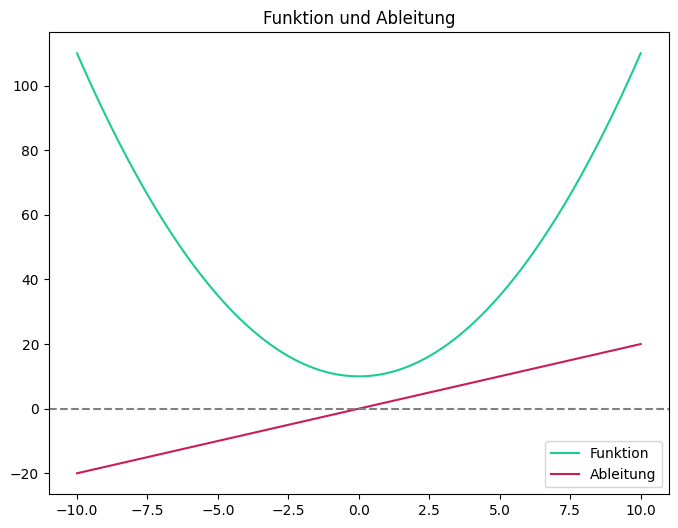

In [11]:
import matplotlib.pyplot as plt
import numpy as np

weight = np.linspace(-10,10,100)
y = (weight**2) + 10

plt.figure(figsize=(8,6))
plt.plot(weight,y,label="Funktion",color="#1ACC94")
plt.plot(weight,2*weight,label="Ableitung",color="#CC1B58")
plt.axhline(y=0,ls="--",c="grey")
plt.title('Funktion und Ableitung')
plt.legend()
plt.show()

## Throwback 

### MSE validieren

In [12]:
studying = torch.tensor([84, 1323, 282, 957, 1386, 810, 396, 474, 501, 660, 1260, 1005, 1110, 1290],dtype=torch.float)
weight = torch.tensor([0.75], requires_grad=True)
result = torch.tensor([44, 97, 30, 51, 95, 51, 44, 41, 21, 40, 90, 83, 61, 92],dtype=torch.float)

def mse(w):
    return (result - (studying*w)).pow(2).mean()

print(mse(weight))

tensor(394252.7500, grad_fn=<MeanBackward0>)


![Image of Yaktocat](https://full-stack-machine-learning.s3.eu-central-1.amazonaws.com/fsml-nb-01-img-01.jpg)

### Gradient berechnen

In [13]:
mse(weight).backward() #PyTorch Ableitung der Error Funktion

#Äquivalente Ergebnisse
print("Ableitung: ",(2*studying*((studying*weight)-result)).mean().item())
print("Gradient von PyTorch: ", weight.grad.item())

Ableitung:  1157081.625
Gradient von PyTorch:  1157081.625


### Naive Gradient Descent

In [14]:
w = torch.rand(1,requires_grad=True)

for i in range(20):
    mse(w).backward()
    w = w.detach() - 0.000001 * w.grad
    w.requires_grad=True

print('MSE nach 20 Iterationen: ',mse(w).item())
print('Optimales Gewicht: ',w.item())

MSE nach 20 Iterationen:  204.6558380126953
Optimales Gewicht:  0.06932257115840912


### Loss Function statt eigener Funktion

In [15]:
loss = torch.nn.MSELoss()
w = torch.rand(1,requires_grad=True)

for i in range(20):
    error = loss(studying*w,result)
    error.backward()
    w = w.detach() - 0.000001 * w.grad
    w.requires_grad=True

print('MSE nach 20 Iterationen: ',loss(studying*w,result).item())
print('Optimales Gewicht: ',w.item())

MSE nach 20 Iterationen:  204.7742919921875
Optimales Gewicht:  0.06946216523647308


### Optimizer statt eigener Gewichtsanpassung

In [16]:
loss = torch.nn.MSELoss()
w = torch.rand(1,requires_grad=True)
optimizer = torch.optim.SGD([w], lr=0.000001)

for i in range(20):
    optimizer.zero_grad()
    error = loss(studying*w,result).backward()
    optimizer.step()

print('MSE nach 20 Iterationen: ',loss(studying*w,result).item())
print('Optimales Gewicht: ',w.item())

MSE nach 20 Iterationen:  204.54689025878906
Optimales Gewicht:  0.0691303238272667


## Neuronale Netze

### Model statt Gewicht

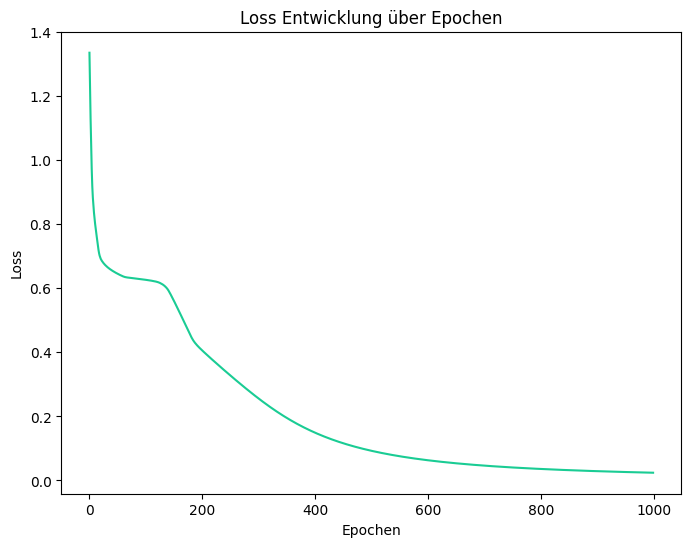

In [17]:
import os
import pandas as pd
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(4,4)
        self.fc2 = nn.Linear(4,1)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

data = torch.from_numpy(
    pd.read_csv(os.path.join("..", "..", "..", "..", "data", "iris_binary.csv")).to_numpy()
).type(torch.FloatTensor)
model = Model()
loss = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epoch_errors = []

for epoch in range(1000):
    optimizer.zero_grad()
    X, y  = data[:,0:-1], data[:,-1:]
    error = loss(model(X),y)
    epoch_errors.append(error.item())
    error.backward()
    optimizer.step()

plt.figure(figsize=(8,6))
plt.plot(epoch_errors,color="#1ACC94")
plt.title('Loss Entwicklung über Epochen')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.show()

### Beliebige Layer im Modell anordnen

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_bn = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16*5*5,200)
        self.fc2 = nn.Linear(200,150)
        self.fc3 = nn.Linear(150,10)

    def forward(self,x):
        x = self.pool1(self.conv1_bn(self.conv1(x)))
        x = self.pool1(self.conv2_bn(self.conv2(x)))

        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

### Torchsummary für Modellüberblick

In [19]:
from torchsummary import summary
net = Net()
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
       BatchNorm2d-2            [-1, 6, 28, 28]              12
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
       BatchNorm2d-5           [-1, 16, 10, 10]              32
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 200]          80,200
            Linear-8                  [-1, 150]          30,150
            Linear-9                   [-1, 10]           1,510
Total params: 114,776
Trainable params: 114,776
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.44
Estimated Total Size (MB): 0.56
-------------------------------------------

### Modell speichern

In [20]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "export.pt")